# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [21]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [22]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [23]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [24]:
def encoder_block(input_layer, filters, strides):
    
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [25]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    output_layer = bilinear_upsample(small_ip_layer)
    
    output_layer = layers.concatenate([output_layer, large_ip_layer])
    
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [ ]:
def fcn_model(inputs, num_classes):
    
    enc_layer1 = encoder_block(inputs, 64, 2)
    enc_layer2 = encoder_block(enc_layer1, 128, 2)

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    one_conv = conv2d_batchnorm(enc_layer2, 256, 1, 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    dec_layer1 = decoder_block(one_conv, enc_layer1, 128)
    x = decoder_block(dec_layer1, inputs, 64)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [66]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [67]:
steps_per_epoch = 100
validation_steps = 50
workers = 4

### Genetic Algorithm

In this step, I attempt to find optimal hyperparameters by using a genetic algorithm. This is purely for fun and to explore a new concept outside of this course!

How does a genetic algorithm work?

    1) We create a population of randomly generated members.
    2) Next, we score each member of the population based on some goal. This score is called a fitness function.
    3) Then, we select and 'breed' the best members of the population to produce more like them.
    4) We will then mutate some members randomly to attempt to find even better candidates.
    5) Finally, we kill off the rest (survival of the fittest)!

After step 5, we have refilled the population to its starting size (via children) and repeat steps 2 - 5. Each cycle through these steps is called a generation. So say we start with a population of 10 members and we want to do 5 generations. After we fit them to a fitness function, we pick the top 3 members of the population and 2 randomly of the 7 worst performing ones (for diversity!). We now have a population of 5 members. At this point, we 'breed' amongst the 5 members (ensuring that the 'mom' and 'dad' are not the same networks) until we regain a population of 10. Then we randomly mutate (by randomly changing the hyperparameters) members of the population. This step would be performed 5 times, to give you 5 generations.

#### Why a genetic algorithm

Let’s say it takes five minutes to train and evaluate a network on our dataset. And let’s say we have four parameters with five possible settings each. To try them all would take (5**4) * 5 minutes, or 3,125 minutes, or about 52 hours.
Now let’s say we use a genetic algorithm to evolve 10 generations with a population of 20, with a plan to keep the top 25% plus a few more, so ~8 per generation. This means that in our first generation we score 20 networks (20 * 5 = 100 minutes). Every generation after that only requires around 12 runs, since we don’t have the score the ones we keep. That’s 100 + (9 generations * 5 minutes * 12 networks) = 640 minutes, or 11 hours. So a genetic algorithm approach to finding optimal hyperparameters is much quicker (in this case, 80%!) than a brute force search approach.

I should also note that in addition to keeping a certain percentage of top performers, we will also be keeping a small percentage of hyperparameters that don't perform that well. Why? Well, we want to promote parameter diversity. One of the dangers of optimization algorithms is getting stuck at a local maximum and consequently being unable to find the real maximum. By including some individuals who are not performing as well, we decrease our likelihood of getting stuck. Mutating the childern also help to promote diversity (although the chance of mutation is quite low).


#### How this will be implemented for this project

Ultimately, this is just an experimentation and a chance for me to look at something new and interesting that can apply to this project and course! Getting the project submitted and accepted is far more important for me to accomplish before running out of AWS credits! However, once accepted, I want to run through a full training session with realistic hyperparameters. Just for the sake of testing and seeing the network run, I have set up two sets of hyperparameters: A test set and a real set. The test set are some simple and quick running hyperparameters solely for the purpose of watching the algorithm work. These will perform terribly, but give quick output of what the network is performing through print statements. If you would like to see the algorithm work, just use the test hyperparameters. Once my project is completed and accepted, I plan on using the rest of my AWS credits to run a full training session using the algorithm and the real hyperparameters. For testing, each generation will consist of 5 individuals, and I run this algorithm for 5 generations. In a real training situation, I would have a population of at least 10 individuals per generations, and run for between 15-20 generations. I tried to comment the code as best as I could to explain the process as I went along.

#### Possible improvements

This is a rough implementation. I fully conceded that many things could be coded more robustly, but it is good enough to get an idea of how this works! One addition that I am particularly interested in is to include different network architectures as part of the traits. This way I could have multiple different networks, of all different numbers of encoders/decoders/1x1 convolutions, to run and evolve along with the hyperparameters. I would be quite interested in seeing how how the generations evolve and what networks/hyperparameters emerge as the strongest. Hopefully, provided I have enough AWS credits left over, I can find out!


In [71]:
from random import random, randint

# These are being used for test runs, to make sure everything works and to quickly see the genetic algorithm
# in action quickly

epochs_test = [1, 2, 3]
batch_size_test = [6, 12, 24]
learning_rate_test = [0.5, 0.1, 0.05]
traits_test = [epochs_test, batch_size_test, learning_rate_test]

# These are for real runs. This will take a while to go through, so I will test these if I have AWS credits left
# over after this project is accepted! In actuality, I would like a few more of each for further testing. I think
# it would also be interesting to include different model architectures (more encoding/decoding layers, etc) as part of
# the parameters

# epochs = [10, 30, 50]
# batch_size = [32, 64, 128]
# learning_rate = [0.001, 0.005, 0.01]
# traits = [epochs, batch_size, learning_rate]

def individual():
    # The last entry in this list, 0, will later be used to store the fitness of this individual
    return [traits[0][randint(0,len(epochs) - 1)], traits[1][randint(0,len(batch_size) - 1)], 
            traits[2][randint(0, len(learning_rate) - 1)], 0]

def population(number):
    return [ individual() for x in range(number) ]

def breed(father, mother):
    # Here, I'm making sure that at least 1 trait comes from both father and mother
    # This assumes 3 traits. Could make more robust to allow different number of traits
    f_traits = randint(1,2)
    
    # Build a child using the traits of the parents
    # Traits could possibly be randomized a little better
    child = father[:f_traits] + mother[f_traits:3] + [0]
    return child

def mutate(individual):
    # This takes a randomly selected trait to swap out in the individual. This incorporates random mutations
    # in the population.
    trait_to_modify = randint(0, len(traits) - 1)
    value_to_modify_with = randint(0, len(traits[trait_to_modify]) - 1)
    individual[trait_to_modify] = traits[trait_to_modify][value_to_modify_with]
    
    
    

Inital generation: [[3, 6, 0.5, 0], [1, 6, 0.1, 0], [3, 6, 0.5, 0], [2, 6, 0.1, 0], [3, 6, 0.5, 0]]
Generation: 0, individual: [3, 6, 0.5, 0]
Using epochs: 3, batch size: 6, learning rate: 0.5
Epoch 1/3
 99/100 [============================>.] - ETA: 0s - loss: 0.2793

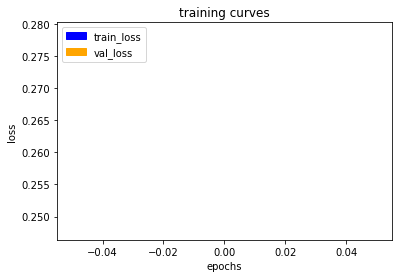

100/100 [==============================] - 19s - loss: 0.2787 - val_loss: 0.2479
Epoch 2/3
 43/100 [===========>..................] - ETA: 7s - loss: 0.3706

In [ ]:
# Generate an initial population of 5 members.
generation = population(5)

print("Inital generation: {}".format(generation))

# In this case, we are doing 5 generations. This can be changed by changing the integer in the below for loop.
for i in range(5):
    for index, individual in enumerate(generation):
        # No need to score top performers networks after first generation.
        if i > 0 and index < len(generation) * 0.4:
            continue
        
        print("Generation: {}, individual: {}".format(i, individual))
        print("Using epochs: {}, batch size: {}, learning rate: {}".format(individual[0], individual[1], individual[2]))
        model = models.Model(inputs=inputs, outputs=output_layer)

        model.compile(optimizer=keras.optimizers.Adam(individual[2]), loss='categorical_crossentropy')

        # Data iterators for loading the training and validation data
        train_iter = data_iterator.BatchIteratorSimple(batch_size=individual[1],
                                                       data_folder=os.path.join('..', 'data', 'train'),
                                                       image_shape=image_shape,
                                                       shift_aug=True)

        val_iter = data_iterator.BatchIteratorSimple(batch_size=individual[1],
                                                     data_folder=os.path.join('..', 'data', 'validation'),
                                                     image_shape=image_shape)

        logger_cb = plotting_tools.LoggerPlotter()
        callbacks = [logger_cb]

        model.fit_generator(train_iter,
                            steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                            epochs = individual[0], # the number of epochs to train for,
                            validation_data = val_iter, # validation iterator
                            validation_steps = validation_steps, # the number of batches to validate on
                            callbacks=callbacks,
                            workers = workers)

        run_num = 'run_1'

        val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                                run_num,'patrol_with_targ', 'sample_evaluation_data') 

        val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                                run_num,'patrol_non_targ', 'sample_evaluation_data') 

        val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                                run_num,'following_images', 'sample_evaluation_data')

        true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)
        true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)
        true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

        true_pos = true_pos1 + true_pos2 + true_pos3
        false_pos = false_pos1 + false_pos2 + false_pos3
        false_neg = false_neg1 + false_neg2 + false_neg3

        weight = true_pos/(true_pos+false_neg+false_pos)

        final_IoU = (iou1 + iou3)/2

        final_score = final_IoU * weight
        print("FINAL SCORE: {}".format(final_score))

        # Set score for individual
        # For this project, a score of 0.4 was acceptable as passing, but I decided to make the acceptance score a little
        # larger.
        individual[3] = 0.6 - final_score
        print()
        print("Score for this individual: {0:.10f}".format(individual[3]))
        print()
        print()
    
    print("Finishing generation: {}".format(i))
    # If we aren't on the last generation
    if i < 5:
        # Sort population by fitness, with a lower score meaning a greater fitness
        generation = sorted(generation, key=lambda x: x[3])

        # Seed the next generation with the top 40% performers, and take 20% of the remaining population as a random
        # selected individual.
        parents_count = int(len(generation) * 0.4)
        random_individual_count = int(len(generation) * 0.2)
        survivors_count = (parents_count + random_individual_count) - 1
        generation = generation[:parents_count] + [generation[randint(2, 4)] for x in range(random_individual_count)]
        
        print("Top performers and randomly selected individuals: {}".format(generation))
        
        # Now we 'breed' the top performers with the randomly selected individuals to replenish the population
        while len(generation) < 5:
            father = randint(0, survivors_count) 
            mother = randint(0, survivors_count)

            # We don't want the father and mother to be the same individual
            if father == mother:
                continue
            else:
                child = breed(generation[father], generation[mother])
                print("Child: {}".format(child))
                generation.append(child)
                
        print("Repopulated: {}".format(generation))
        
        # Next we introduce random mutation (2% chance) to the children and least performing network
        chance_to_mutate = 0.02
        for entity in generation[survivors_count:]:
            if chance_to_mutate > random():
                print("Mutating child")
                mutate(entity)


                
    print("New generation: {}".format(generation))
    print()
            
    
for i in generation:
    print("Epochs: {}", i[0])
    print("Batch size: {}", i[1])
    print("Learning rate: {}", i[2])
    print("Final score: {}", i[3])
    
print("Top performing hyperparameters: {}".format(generation[0]))
    